In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import time
import sys
import os

/home/arunima/aru_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
### Fixing some values for the hyperparameters 
batch_size=50
epochs=10

In [5]:
## If GPU is abailable, then the code will be pushed to it otherwise it will move to CPU 
use_cuda=torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
##Loading the data
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_data = datasets.MNIST(root='../data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='../data', train=False,download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
##Building the CNN structure, without Batch-normalization

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),nn.MaxPool2d(kernel_size=2,stride=2))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),nn.MaxPool2d(kernel_size=2,stride=2))
        self.fclayer1=nn.Sequential(nn.Linear(7*7*32, 500), nn.ReLU())
        self.fclayer2=nn.Linear(500,10)
        
    def forward(self,x):
        output=self.conv1(x)
        output=self.conv2(output)
        out=output.view(-1,7*7*32)
        output=self.fclayer1(out)
        output=self.fclayer2(output)
        output= F.log_softmax(output, dim=1)
        return output
    
##Building the CNN structure, with Batch-normalization
    
class CNN_with_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_with_BatchNorm,self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(32),nn.ReLU(),nn.MaxPool2d(kernel_size=2,stride=2))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(32),nn.ReLU(),nn.MaxPool2d(kernel_size=2,stride=2))
        self.fclayer1=nn.Sequential(nn.Linear(7*7*32, 500),nn.BatchNorm1d(500), nn.ReLU())
        self.fclayer2=nn.Linear(500,10)
        
    def forward(self,x):
        output=self.conv1(x)
        output=self.conv2(output)
        out=output.view(-1,7*7*32)
        output=self.fclayer1(out)
        output=self.fclayer2(output)
        output= F.log_softmax(output, dim=1)
        return output

In [8]:
#Training on the images

def train(model,device,train_loader,optimizer,epoch,train_loss,train_accuracy):
    model.train()
    acc=0
    train_l=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        #train_loss.append(loss.item())
        train_l+=loss.item()
        pred= output.argmax(dim=1, keepdim=True)
        acc+= pred.eq(target.view_as(pred)).sum().item()
        
    train_loss.append(train_l/len(train_loader.dataset))
    train_accuracy.append(100*acc/len(train_loader.dataset))
        
    
    

In [9]:
def test(model,device,test_loader,test_loss,test_accuracy):
    model.eval()
    loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            acc += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)
    test_accuracy.append(100. * acc / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, acc, len(test_loader.dataset),
        100. * acc / len(test_loader.dataset)))

## $Question$ $1$

In [10]:
cnn=CNN()
model=cnn.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
start=time.time()
for epoch in range(1,epochs+1):
    train(model,device,train_loader,optimizer,epoch,train_loss,train_accuracy)
    
    test(model, device, test_loader,test_loss,test_accuracy)
end=time.time()


Test set: Average loss: 0.1097, Accuracy: 9676/10000 (97%)


Test set: Average loss: 0.0602, Accuracy: 9804/10000 (98%)


Test set: Average loss: 0.0526, Accuracy: 9824/10000 (98%)


Test set: Average loss: 0.0425, Accuracy: 9869/10000 (99%)


Test set: Average loss: 0.0371, Accuracy: 9871/10000 (99%)


Test set: Average loss: 0.0375, Accuracy: 9875/10000 (99%)


Test set: Average loss: 0.0318, Accuracy: 9893/10000 (99%)


Test set: Average loss: 0.0301, Accuracy: 9899/10000 (99%)


Test set: Average loss: 0.0283, Accuracy: 9899/10000 (99%)


Test set: Average loss: 0.0273, Accuracy: 9910/10000 (99%)



In [12]:
avg_acc=sum(test_accuracy)/10
print("The average accuracy of the test set is : {:.6f} without batch-normalization.".format(avg_acc))

The average accuracy of the test set is : 98.520000 without batch-normalization.


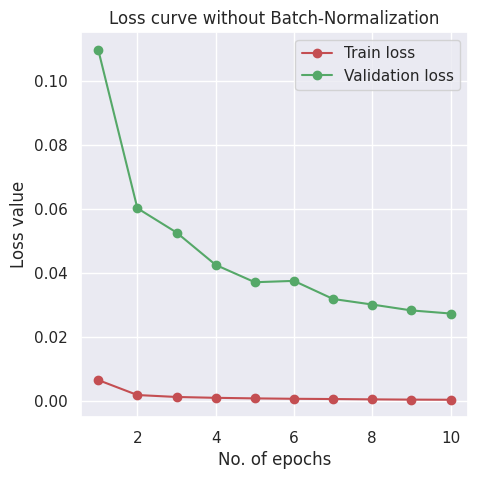

In [13]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,11,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Validation loss"])
plt.title("Loss curve without Batch-Normalization")
plt.grid(True)

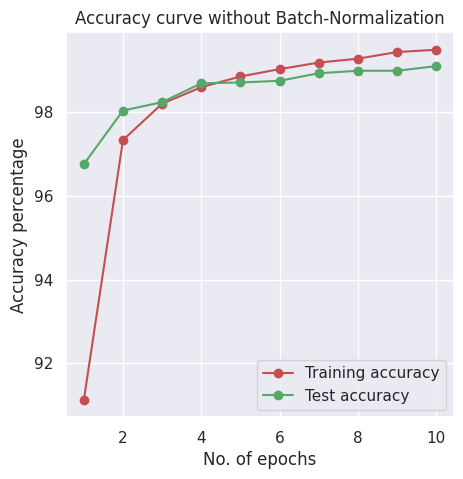

In [14]:
plt.figure(figsize=(5, 5))
x=np.arange(1,11,1)
plt.plot(x,train_accuracy,color='r',marker='o')
plt.plot(x,test_accuracy,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy percentage")
plt.legend(["Training accuracy","Test accuracy"])
plt.title("Accuracy curve without Batch-Normalization")
plt.grid(True)

In [15]:
def random_plotting_of_test_images(network,test_loader):
    image_index= np.random.randint(low=0, high=9999, size=3) #test set has 10000 images
    for index in image_index:
        test_image = test_loader.dataset.data[index, :, :].clone()
        with torch.no_grad():#Using no_grad as it reduces memory consumption for computation.
            test_image = test_image.reshape(1,1,28,28).cuda().float()
            out = network.forward(test_image).detach().cpu().numpy()
        predicted=np.argmax(out)
        plt.imshow(test_image.detach().cpu().numpy().reshape(28,28),cmap='viridis')
        plt.axis('off')
        plt.title(f"Predicted as {predicted}")

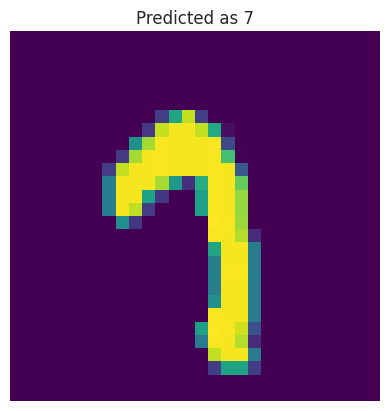

In [16]:
random_plotting_of_test_images(model,test_loader)

In [17]:
print("The time taken to run the model without Batch-Normalization is {:.6f} seconds".format(end-start))

The time taken to run the model without Batch-Normalization is 59.512161 seconds


In [18]:
##### Implementing Batch-Normalization

cnn_batch_norm=CNN_with_BatchNorm()
model_batch_norm=cnn_batch_norm.to(device)
optimizer_bn = optim.Adam(model_batch_norm.parameters(), lr=0.0001)


In [19]:
train_loss_bn=[]
train_accuracy_bn=[]
test_loss_bn=[]
test_accuracy_bn=[]
start_bn=time.time()
for epoch in range(1,epochs+1):
    train(model_batch_norm,device,train_loader,optimizer_bn,epoch,train_loss_bn,train_accuracy_bn)
    
    test(model_batch_norm, device, test_loader,test_loss_bn,test_accuracy_bn)
end_bn=time.time()


Test set: Average loss: 0.0506, Accuracy: 9867/10000 (99%)


Test set: Average loss: 0.0407, Accuracy: 9877/10000 (99%)


Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99%)


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99%)


Test set: Average loss: 0.0271, Accuracy: 9912/10000 (99%)


Test set: Average loss: 0.0265, Accuracy: 9912/10000 (99%)


Test set: Average loss: 0.0308, Accuracy: 9896/10000 (99%)


Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99%)


Test set: Average loss: 0.0276, Accuracy: 9911/10000 (99%)


Test set: Average loss: 0.0247, Accuracy: 9916/10000 (99%)



In [20]:
print("The time taken to run the model with Batch-Normalization is {:.6f} seconds".format(end_bn-start_bn))

The time taken to run the model with Batch-Normalization is 64.753434 seconds


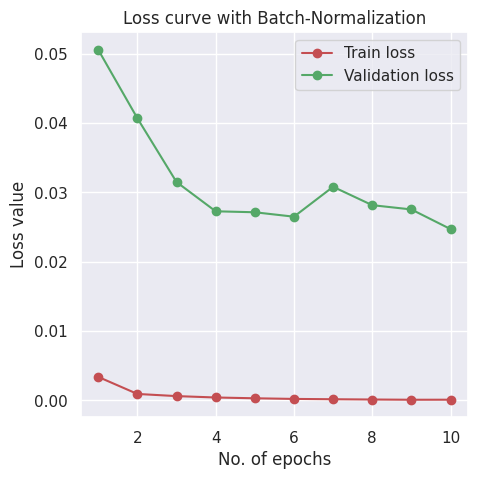

In [21]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,11,1)
plt.plot(xval,train_loss_bn,color='r',marker='o')
plt.plot(xval,test_loss_bn,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Validation loss"])
plt.title("Loss curve with Batch-Normalization")
plt.grid(True)

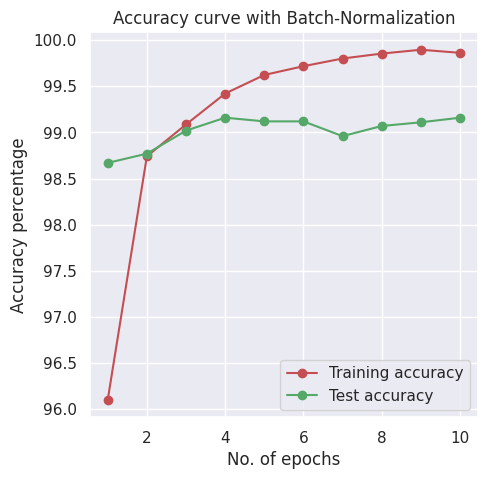

In [22]:
plt.figure(figsize=(5, 5))
x=np.arange(1,11,1)
plt.plot(x,train_accuracy_bn,color='r',marker='o')
plt.plot(x,test_accuracy_bn,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy percentage")
plt.legend(["Training accuracy","Test accuracy"])
plt.title("Accuracy curve with Batch-Normalization")
plt.grid(True)

In [23]:
avg_acc=sum(test_accuracy_bn)/10
print("The average accuracy of the test set is : {:.6f} without batch-normalization.".format(avg_acc))

The average accuracy of the test set is : 99.016000 without batch-normalization.


### $Question$ $2$

In [24]:
def visualize_filter_1(model,rows,column):
    conv1_weights=model.conv1[0].weight.detach().clone()
    conv1_weights=conv1_weights.cpu().numpy()# this is of size(32,1,3,3)
    
    fig = plt.figure(figsize=(8, 8))
    plt.title("Plots for First Convolutional layer filter")
    for i, filters in enumerate(conv1_weights):    
        fig.add_subplot(rows,column , i+1)
        plt.imshow(filters[0,:,:],cmap='Greys')
        plt.axis('off')
    
    
    

In [25]:
def visualize_filter_2(model,rows,column,channel_for_conv2):

    conv2_weights=model.conv2[0].weight.detach().clone()
    conv2_weights=conv2_weights.cpu().numpy()# this is of size (32,32,3,3)
    
    fig = plt.figure(figsize=(5, 5))
    plt.title("Plots for second Convolutional layer for filter {}".format(channel_for_conv2))
    for i, filters in enumerate(conv2_weights):    
        fig.add_subplot(rows,column , i+1)
        plt.imshow(filters[channel_for_conv2,:,:])
        plt.axis('off')
    
    

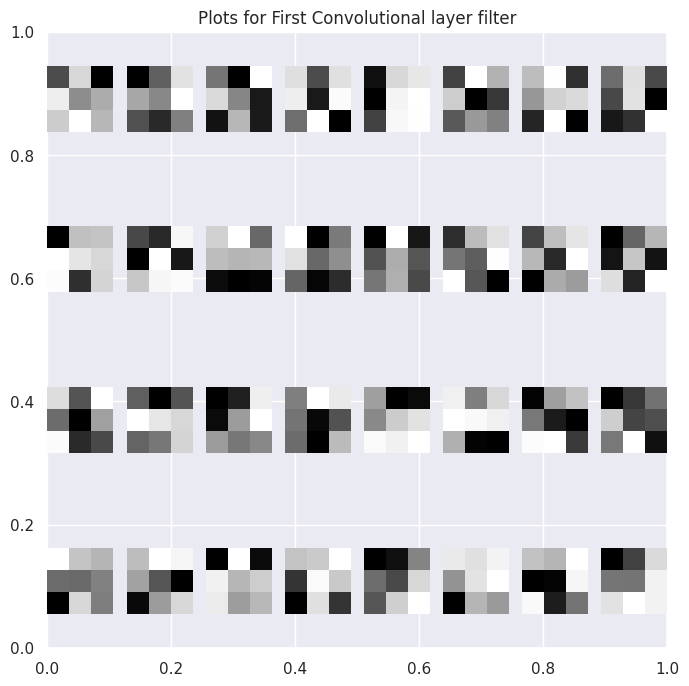

In [26]:
visualize_filter_1(model,rows=4,column=8) #first conv has 32 filters so 32 are shown altogether.

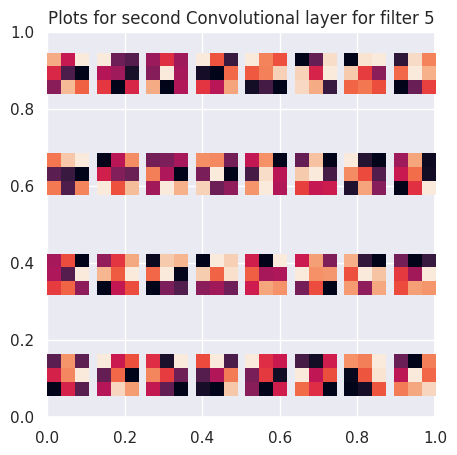

In [27]:
visualize_filter_2(model,rows=4,column=8,channel_for_conv2=5)

In [28]:
def feature_map(model,test_loader):
    image_idx=int(input("select a index from test set whose feature maps you want to visualize\n"))
    test_image = test_loader.dataset.data[image_idx, :, :].clone().reshape(1, 1, 28, 28).clone().cuda().float()
    
    val=test_loader.dataset.targets
    test_image_id=int(val[image_idx].detach().cpu().numpy())
    print("True label of the selected number is",test_image_id)
    #For the first conv2d
    
    with torch.no_grad():
        output_conv1=model.conv1[0].forward(test_image)# the shape is (1,32,28,28)
        output_conv1=output_conv1.reshape(32,1,28,28).cpu().numpy()
        
        fig = plt.figure(figsize=(5, 5))
        plt.title("Plot for feature maps from First Convolutional layer")
        for i, filters in enumerate(output_conv1):    
            fig.add_subplot(4,8,i+1)
            plt.imshow(filters[0,:,:],cmap='viridis')
            plt.axis('off')
            
    #For second conv2d
    
    with torch.no_grad():
        output_conv1=model.conv1.forward(test_image)
        output_conv2=model.conv2[0].forward(output_conv1)# the shape is (1,32,14,14)
        output_conv2=output_conv2.reshape(32,1,14,14).cpu().numpy()
        
        
        fig = plt.figure(figsize=(5, 5))
        plt.title("Plot for feature maps from Second Convolutional layer")
        for i, filters in enumerate(output_conv2):    
            fig.add_subplot(4,8, i+1)
            plt.imshow(filters[0,:,:],cmap='viridis')
            plt.axis('off')
        
    

select a index from test set whose feature maps you want to visualize
0
True label of the selected number is 7


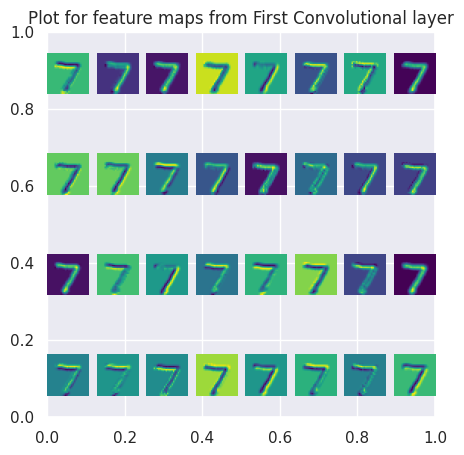

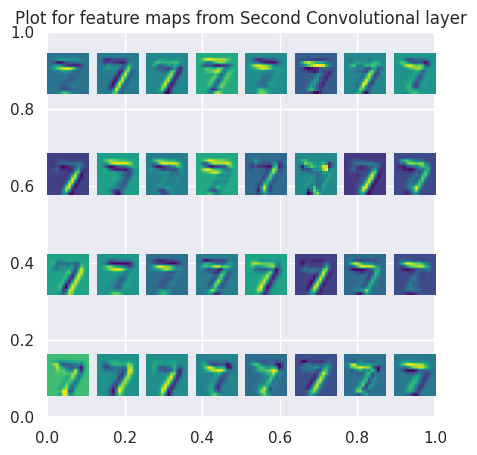

In [29]:
feature_map(model,test_loader)

In [30]:
def occulusion_effects(model,occluding_size,occluding_stride):
    image_idx=int(input("Choose the index for test image for occulusion effect\n"))
    test_image=test_loader.dataset.data[image_idx, :, :].clone()
    
    val=test_loader.dataset.targets
    test_image_id=int(val[image_idx].detach().cpu().numpy())
    print("True label",test_image_id)
    
    height, width= test_image.size()
    output_height = int(np.ceil((height-occluding_size)/occluding_stride+1))
    output_width = int(np.ceil((width-occluding_size)/occluding_stride+1))
    
    probability_map = np.zeros((output_height, output_width))
    max_probable_class_map = np.zeros_like(probability_map)
    fig = plt.figure(figsize=(5, 5))
    for h in range(output_height):
        for w in range(output_width):
            #occluder region
            h_start = h*occluding_stride
            w_start = w*occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            
            input_image = test_image.clone()
            input_image[h_start:h_end,w_start:w_end] =  0
            
            with torch.no_grad():
                input_image = input_image.clone().reshape(1,1,28,28).cuda().float()
            
                out=model.conv1.forward(input_image)
                out=model.conv2.forward(out)
                out=out.reshape(out.size(0), -1)
                out=model.fclayer1.forward(out)
                out=model.fclayer2.forward(out)
                probablities = F.softmax(out, dim=1).cpu().detach().numpy()
                
                prediction = np.argmax(probablities)
                probability = probablities[:, test_image_id]
                probability_map[int(h/2),int(w/2)] = probability[0]
                max_probable_class_map[int(h/2),int(w/2)] = prediction
                
            
            if ((w%4==0)&(h%4==0)):
                        
                        plt.imshow(input_image.cpu().numpy().reshape(28,28))
                        plt.title("probability of  {} is  {:.6f}.".format(
                            test_image_id, probability[0]))
                        plt.show()
        
    print("\n\nProbability of {} as the patch is moved.".format(test_image_id))
    print(probability_map)
    print("\n\nMaximum probable class as the patch is moved.")
    print(max_probable_class_map)
    print("\n\n")
    print(f"predicted class {prediction}")
    ax1=sns.heatmap(probability_map,cmap='flare')
    ax1.set_title(f"Probability Heatmap of class {test_image_id}")
    plt.xlabel("x-patch")
    plt.ylabel("y-patch")
    plt.show()
    
    

Choose the index for test image for occulusion effect
0
True label 7


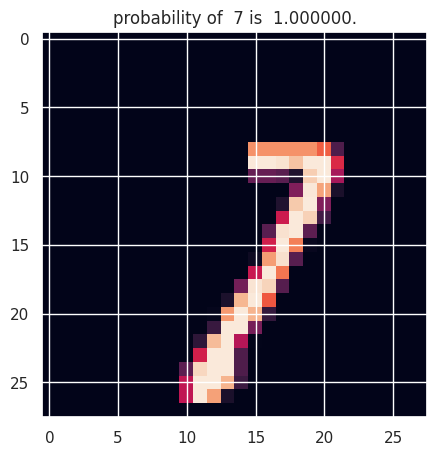

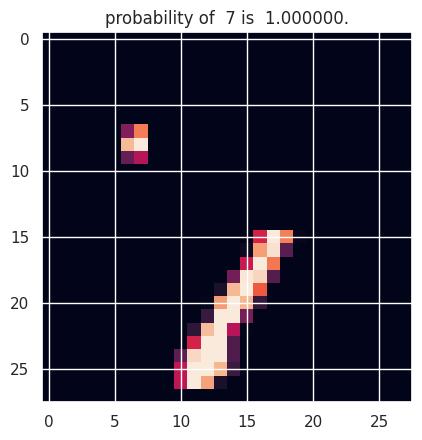

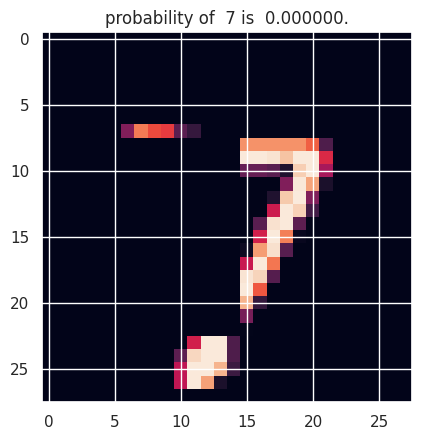

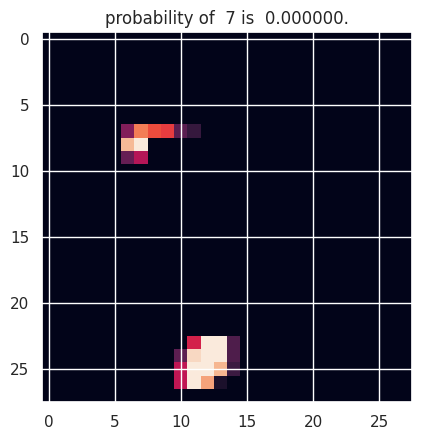



Probability of 7 as the patch is moved.
[[1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 3.83751773e-30 6.84278546e-30 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00

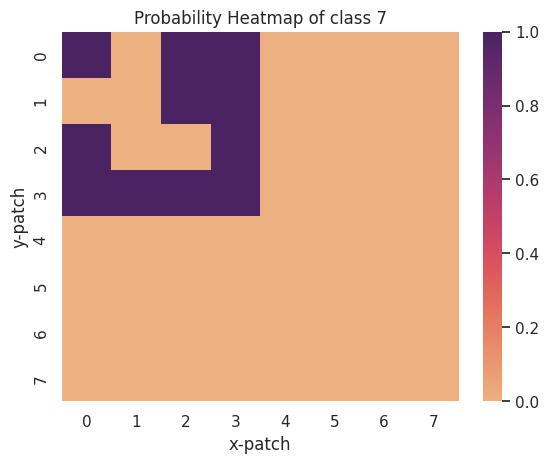

In [31]:
## hyperparameters
occluding_patch=15
occlusing_stride=2

occulusion_effects(model,occluding_patch,occlusing_stride)
#Larger patch size makes the network inefficient 

### $Question$ $3.1:$ $ Non-Targeted $ $ attack $

In [32]:
def non_targeted_attack(network,non_targetted_steps,step_size):
    
    noise = np.random.normal(loc=128, scale=10, size=(28,28))
    noise_tensor = torch.from_numpy(noise).reshape(1,1,28,28).cuda().float()
    
    for class_label in range(10):
        target_class=class_label
        
        noise_tensor =  torch.tensor(noise_tensor.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')
        
        logit_values=[]#the output just after softmax
        
        for step in range(non_targetted_steps):
            
            noise_tensor = Variable(noise_tensor, requires_grad=True)
            out = network.conv1.forward(noise_tensor)
            out = network.conv2.forward(out)
            out = out.reshape(out.size(0), -1)
            out = network.fclayer1.forward(out)
            out = network.fclayer2.forward(out)
            loss=out[:,target_class]
            
            
            logit_values.append(loss.cpu().detach().numpy())
            
            loss.backward(retain_graph=True)#this will store the intermediatory results while doing backprop
            
            grad=torch.sign(noise_tensor.grad.data)
            
            noise_tensor=noise_tensor + grad*step_size #following gradient ascent not gradient descent
        
        plt.clf()
        fig = plt.figure(figsize=(5, 5))    
        plt.plot(np.asfarray(logit_values))
        plt.title(f"Cost function for {target_class}")
        plt.grid(True)
        plt.show()
        
        adversarial= noise_tensor.cpu().reshape(28,28).detach().numpy()
        adversarial = adversarial - np.min(adversarial)
        adversarial = adversarial/np.max(adversarial)
        plt.imshow(adversarial,cmap='crest')
        plt.title(f"Generated image of {target_class}")
        plt.show()
        
            
            
            
        

/tmp/ipykernel_99717/1118582683.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_tensor =  torch.tensor(noise_tensor.type(torch.cuda.FloatTensor), requires_grad=True, device='cuda')


<Figure size 640x480 with 0 Axes>

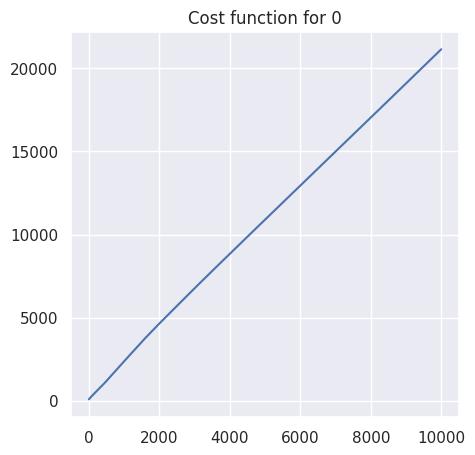

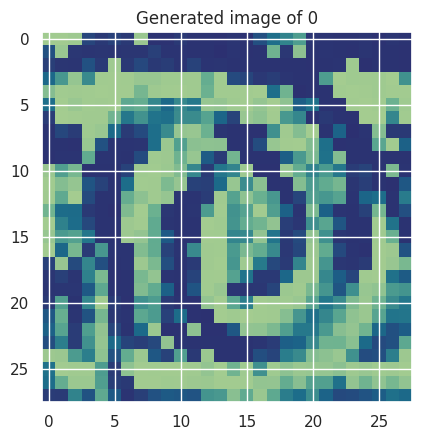

<Figure size 640x480 with 0 Axes>

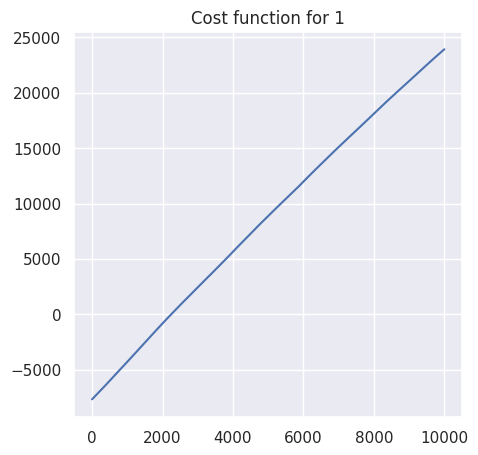

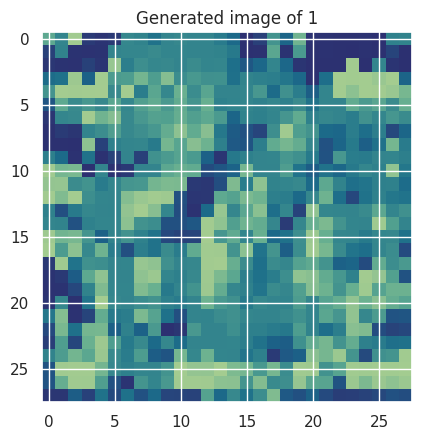

<Figure size 640x480 with 0 Axes>

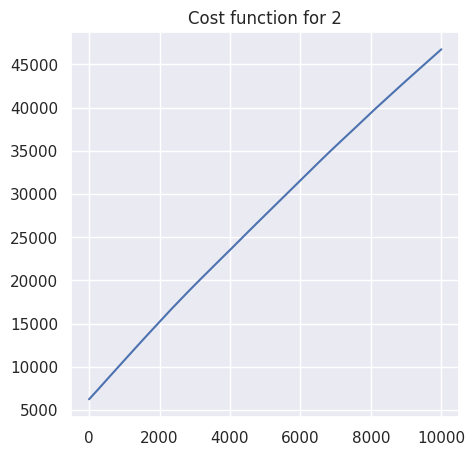

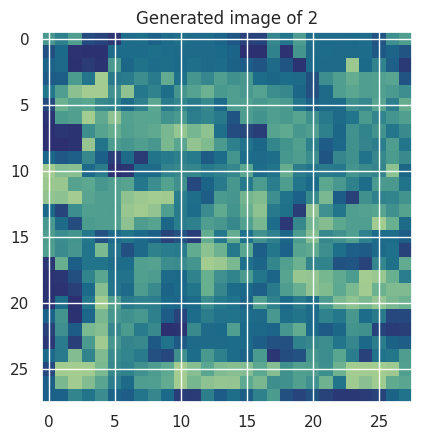

<Figure size 640x480 with 0 Axes>

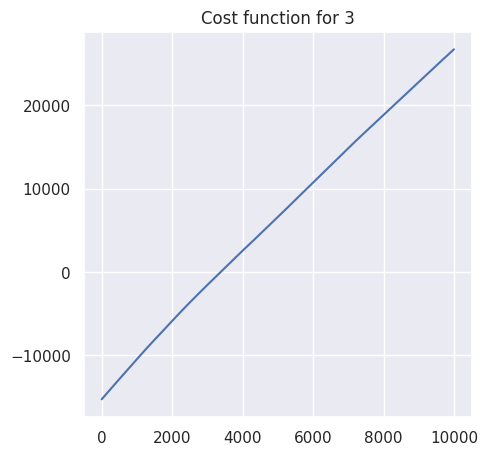

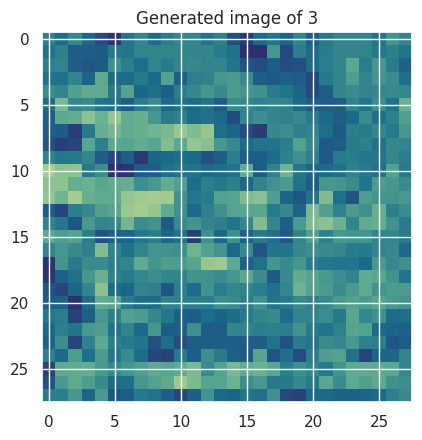

<Figure size 640x480 with 0 Axes>

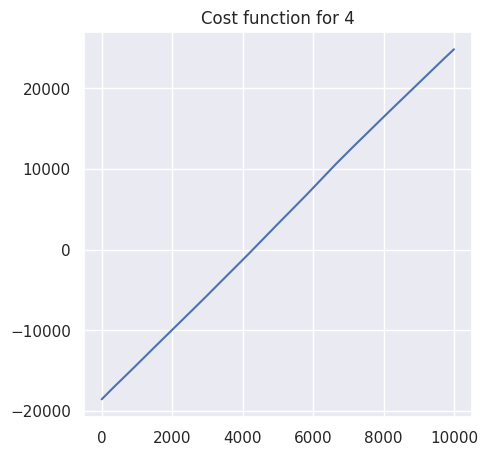

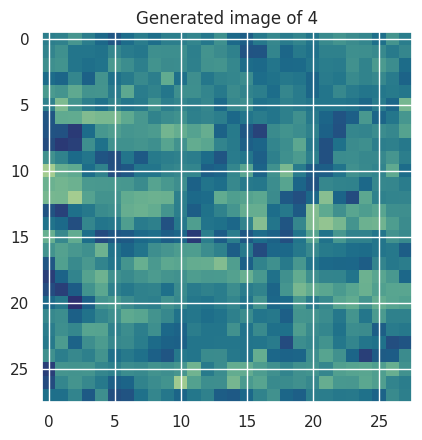

<Figure size 640x480 with 0 Axes>

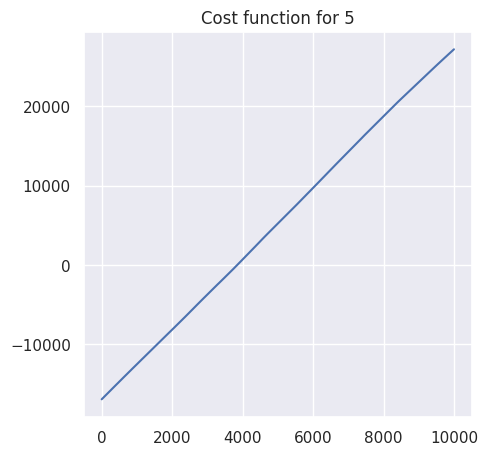

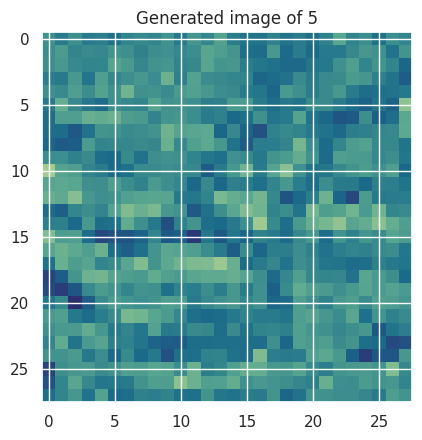

<Figure size 640x480 with 0 Axes>

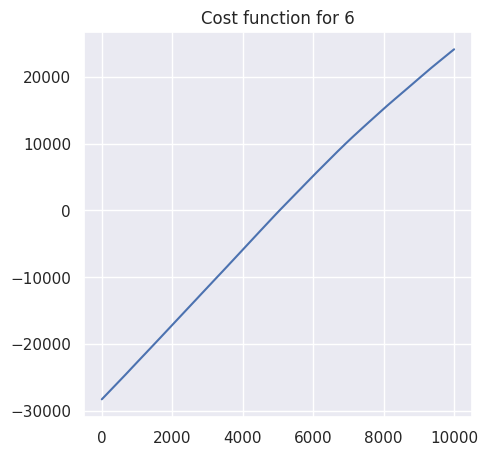

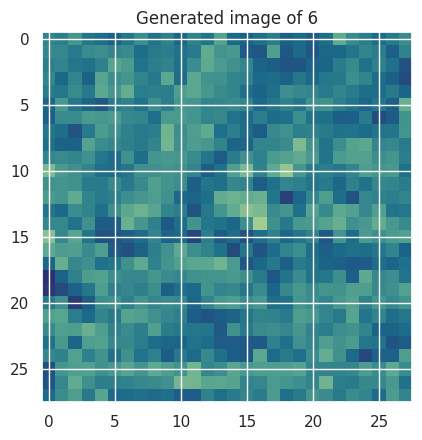

<Figure size 640x480 with 0 Axes>

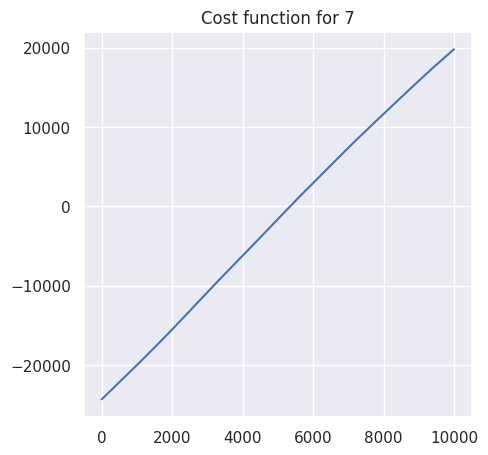

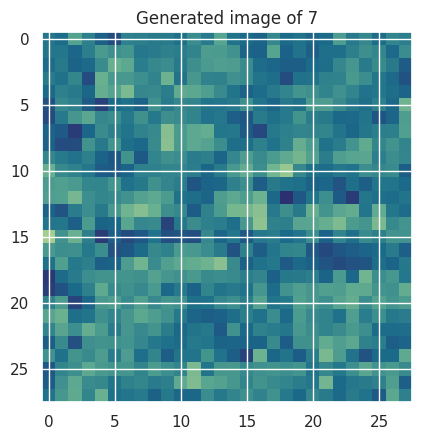

<Figure size 640x480 with 0 Axes>

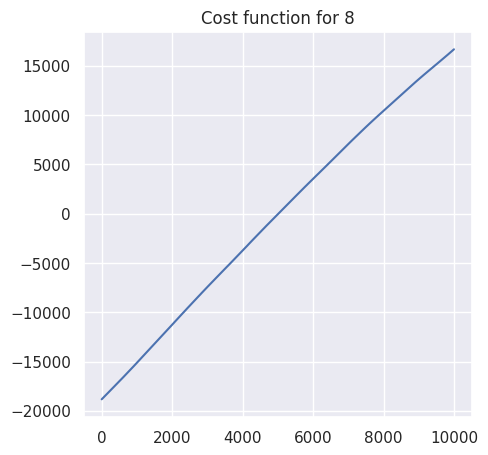

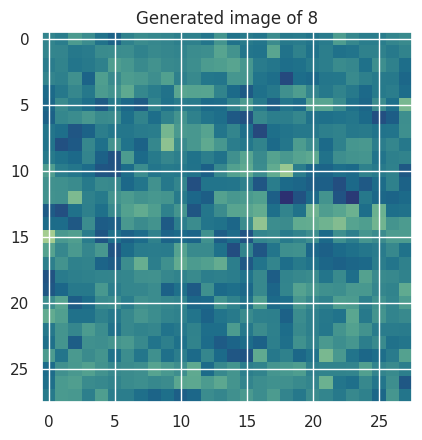

<Figure size 640x480 with 0 Axes>

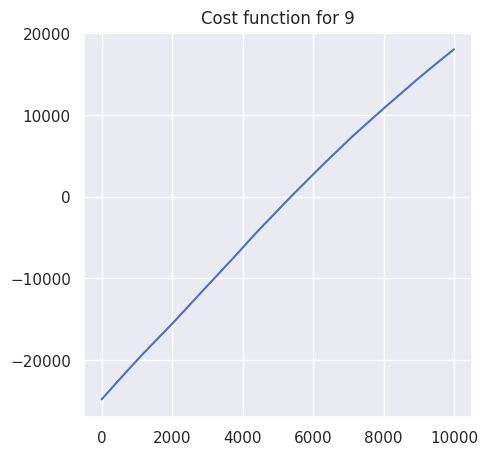

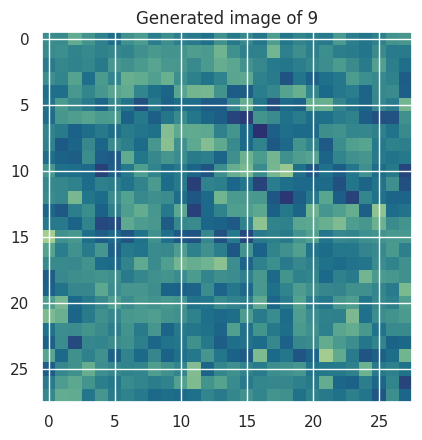

In [33]:
non_targeted_attack(model,non_targetted_steps=10000,step_size=0.1)

## $Question$ $3.2:$ $Targeted$ $Attack$

In [47]:
def targetted_attack(network,targetted_steps=1000,step_size=0.01,beta=0.00001):
    
    original_image_index=int(input("Enter a index value for the original image that should be generated : "))
    misclassified_image_index=int(input("Enter the index for the target image that will misclassify to : "))
    
    
    #the image that has to be generated
    target_image = test_loader.dataset.data[original_image_index, :,:].clone().reshape(1,1,28,28).cuda().float()
    
    val=test_loader.dataset.targets
    original_image_id=int(val[original_image_index].detach().cpu().numpy())
    misclassified_image_id=int(val[misclassified_image_index].detach().cpu().numpy())
    #print(f"Original number generated is {original_image_id}  and number it will misclassify to is {target_image_id}")
    
    
    #Creating noise from which target_image will be generated
    
    noise = np.random.normal(loc=128, scale=10, size=(28,28))
    noise_tensor = torch.from_numpy(noise).reshape(1,1,28,28).cuda().float()
    
    
    for step in range(targetted_steps):
            
        noise_tensor = Variable(noise_tensor, requires_grad=True)
        out = network.conv1.forward(noise_tensor)
        out = network.conv2.forward(out)
        out = out.reshape(out.size(0), -1)
        out = network.fclayer1.forward(out)
        out = network.fclayer2.forward(out)
        probablities = F.softmax(out, dim=1)
        
        
        logit=out[:, misclassified_image_id]
        mse_error = F.mse_loss(noise_tensor, target_image)
        
        loss=logit-beta*mse_error
        
        loss.backward(retain_graph=True)
        input_grad = torch.sign(noise_tensor.grad.data)
        noise_tensor = noise_tensor+step_size*input_grad
        
    misclass_porb=probablities[:,misclassified_image_id].cpu().detach().numpy()
    img_gen= noise_tensor.cpu().reshape(28,28).detach().numpy()
    
    f,axarr=plt.subplots(1,2,figsize=(8, 8))
    axarr[0].imshow(target_image.cpu().reshape(28,28).numpy())
    axarr[0].set_title(f"Original number chosen is {original_image_id}")
    axarr[0].axis("off")
    axarr[1].imshow(img_gen)
    axarr[1].set_title(f"Generated Image:\nclassified as {misclassified_image_id} \nwith probability {misclass_porb}")
    axarr[1].axis("off")
    plt.show()
    
    
    

Enter a index value for the original image that should be generated : 12
Enter the index for the target image that will misclassify to : 2


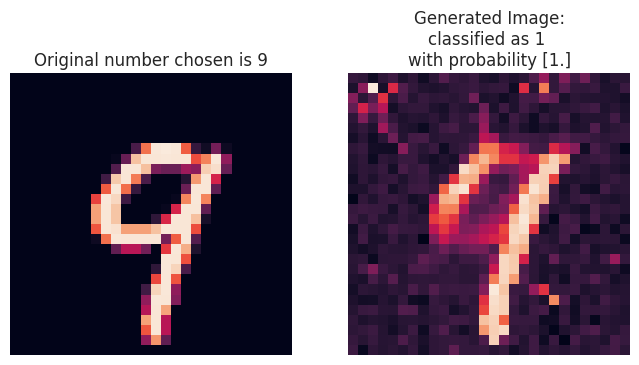

In [57]:
targetted_attack(model,targetted_steps=1000,step_size=0.1,beta=0.5)

### $Question$ $3.3 :$ $Noise$ $Addition$

In [91]:
def noise_addition(network,original_image_index,misclassified_image_index,another_image_index,alpha):
    
    #original_image_index=int(input("Enter a index value for the original image that should be made noisy : "))
    #misclassified_image_index=int(input("Enter the index for the target image that will misclassify to : "))
    
    
    #the image that will be misclasisified by adding noise
    target_image = test_loader.dataset.data[original_image_index, :,:].clone().reshape(1,1,28,28).cuda().float()
    
    val=test_loader.dataset.targets
    original_image_id=int(val[original_image_index].detach().cpu().numpy())
    misclassified_image_id=int(val[misclassified_image_index].detach().cpu().numpy())
    
    
    #noise tensor that will be updated so that original class is misclassified
    noise = np.zeros((28,28))
    noise_tensor = torch.from_numpy(noise).reshape(1,1,28,28).cuda().float()
    
    class_max_prob=original_image_id
    
    while(class_max_prob!=misclassified_image_id):
        
        noise_tensor = Variable(noise_tensor, requires_grad=True)
        out = network.conv1.forward(noise_tensor+target_image)
        out = network.conv2.forward(out)
        out = out.reshape(out.size(0), -1)
        out = network.fclayer1.forward(out)
        out = network.fclayer2.forward(out)
        
        probablity = F.softmax(out, dim=1).cpu().detach().numpy()
        class_max_prob=int(np.argmax(probablity))
        
        prob_misclassified=probablity[:,misclassified_image_id]
    
        loss=out[:,misclassified_image_id]
        
        loss.backward(retain_graph=True)
        
        #Normalizing the derivatives
        grad = torch.sign(noise_tensor.grad.data)
        grad = grad - grad.min()
        grad = grad/grad.max()
        
        noise_tensor=noise_tensor+ alpha*grad
        
    noisy_image=(noise_tensor+target_image).cpu().reshape(28,28).detach().numpy()
    noise_of_image=noise_tensor.cpu().reshape(28,28).detach().numpy()
    
    plt.figure(figsize=(8,8))
    f, axarr = plt.subplots(1,3,figsize=(8, 8))
    axarr[0].imshow(target_image.cpu().reshape(28,28).numpy(),cmap='viridis')
    axarr[0].set_title(f"Original image \n True label = {original_image_id}")
    axarr[0].axis('off')
    axarr[1].imshow(noisy_image,cmap='viridis')
    axarr[1].set_title(f"Noisy image,\n True label={original_image_id}\n predicted class = {class_max_prob}")
    axarr[1].axis('off')
    axarr[2].imshow(noise_of_image,cmap='viridis')
    axarr[2].set_title(f"Noise added")
    axarr[2].axis('off')
    plt.show() 
    
    ##Adding the noise on another image to see how it clasifies
    
    another_image_id=int(val[another_image_index].detach().cpu().numpy())
    another_image=test_loader.dataset.data[another_image_index, :,:].clone().reshape(1,1,28,28).cuda().float()
    
    
    
    out = network.conv1.forward(noise_tensor+another_image)
    out = network.conv2.forward(out)
    out = out.reshape(out.size(0), -1)
    out = network.fclayer1.forward(out)
    out = network.fclayer2.forward(out)
    prob = F.softmax(out, dim=1).cpu().detach().numpy()
    output_class=int(np.argmax(probablity))

    plt.figure(figsize=(5,5))
    plt.imshow(another_image.cpu().reshape(28,28).detach().numpy())
    plt.title(f"Ture label={another_image_id}\nOutput predicted for another image : {output_class}")
        

<Figure size 800x800 with 0 Axes>

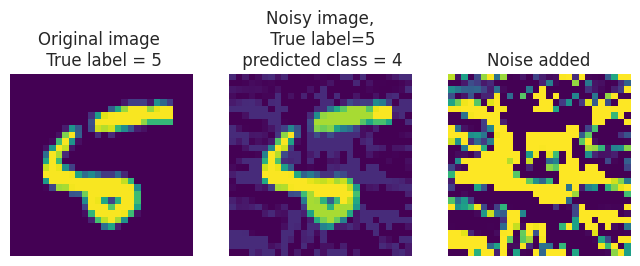

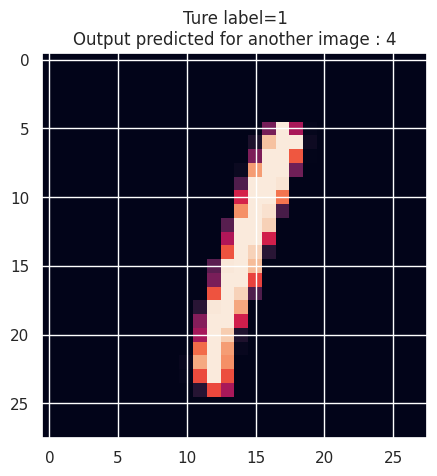

In [92]:
index_list=[13,5,1,18,6,8,11,0,61,12]#Manually hardcoded
import random
original_image_index,misclassified_image_index,another_image=random.sample(index_list,3)
output=noise_addition(model,original_image_index,misclassified_image_index,another_image,0.1)